In [1]:
import sys
sys.path.append('../src')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import tensorflow as tf
from gait.config import pd
from gait.utils import get_data_by_overlap_percent,get_overlap_data_all_sessions,  split_test_train_by_subjects, remove_invalid_data, get_overlap_data_all_sessions
from gait.training import train_2dcnn_lstm_model
from gait.evalution import save_history, save_test_history, save_accuracy_loss_figure, save_confusion_matrix_figure, compute_validations_predictions

In [2]:
def compute_resultant_acceleration(X):
    return np.sqrt(X[:,:,0] **2 + X[:,:,1] ** 2 + X[:,:,2] ** 2)

def compute_resultant_gyro(X):
    return np.sqrt(X[:,:,3] **2 + X[:,:,4] ** 2 + X[:,:,5] ** 2)

def compute_resultant_angle(X):
    return np.sqrt(X[:,:,6] **2 + X[:,:,7] ** 2 + X[:,:,8] ** 2)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
unique subjects ['0DXZFsYOfgqsYe0Z' '0UXFxu10k0En1vDK' '19AoxD1bgrDckd2p'
 '1ZstYhEKzKKfGnMW' 'AlOXZjo87HHkXeaa' 'EUbKPOSQgjccjtvi'
 'I1TuySg6fbJ0xeXt' 'KNmC3LADpLyH5qJA' 'KPJOUYXzpivbLfsH'
 'LLZjAPTyj7muHsEf' 'LdH95bTaViXIdDBZ' 'MMuX9YIh4NTbLZLM'
 'NKdnm6cN3KKAx7R4' 'PE8D53oX060qLbdX' 'QFxq3HxMCbzs6bCt'
 'WAb2Ztvv2ux95P4Q' 'YbJVcb4vFFjKKlfe' 'bQsRwKxgJiXTzo6P'
 'c9EB3mOQckRCc8Bz' 'cbOZWnI7s1y8oLD4' 'csujYZktn88ftTTv'
 'ddAeJA42PXvwthbW' 'eqUcL0HkHZfDt0Xs' 'ewpnQDEzR8hTqPRY'
 'kPNKVxgIznp3Vskg' 'nan' 'psiuhPJmLIa2wC4u' 'qyP4saGxcV9UfeQI'
 'sUZBISq61Y7I5tqQ' 'wtyNo4LYaWXrkzA7' 'xYdtS1F8tDyjEIgN'
 'zOmNofnVfbR21Y7n']
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0

/home/sanjeev/.local/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
385/385 [==============================] - 16s 20ms/step - loss: 0.5381 - accuracy: 0.8042 - val_loss: 0.4159 - val_accuracy: 0.8489
Epoch 2/100
385/385 [==============================] - 6s 15ms/step - loss: 0.3238 - accuracy: 0.8893 - val_loss: 0.2691 - val_accuracy: 0.9058
Epoch 3/100
385/385 [==============================] - 6s 15ms/step - loss: 0.2714 - accuracy: 0.9085 - val_loss: 0.2632 - val_accuracy: 0.9076
Epoch 4/100
385/385 [==============================] - 6s 15ms/step - loss: 0.2352 - accuracy: 0.9206 - val_loss: 0.2320 - val_accuracy: 0.9216
Epoch 5/100
385/385 [==============================] - 6s 15ms/step - loss: 0.2109 - accuracy: 0.9287 - val_loss: 0.1878 - val_accuracy: 0.9382
Epoch 6/100
385/385 [==============================] - 6s 15ms/step - loss: 0.1945 - accuracy: 0.9346 - val_loss: 0.1645 - val_accuracy: 0.9439
Epoch 7/100
385/385 [==============================] - 6s 15ms/step - loss: 0.1798 - accuracy: 0.9406 - val_loss: 0.1651 - val_accuracy

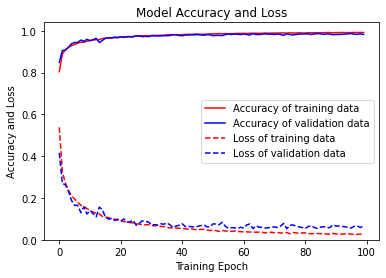

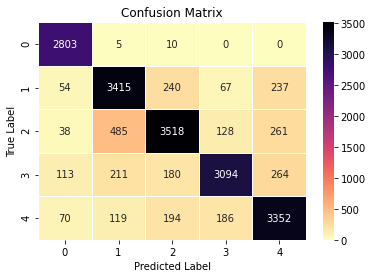

In [3]:
overlapPercents = [80]
# overlapPercents = [0]
exclude_subjects = ['ddAeJA42PXvwthbW', 'nan', 'sUZBISq61Y7I5tqQ', 'LLZjAPTyj7muHsEf',
                    'cbOZWnI7s1y8oLD4', 'EUbKPOSQgjccjtvi', 'MMuX9YIh4NTbLZLM',
                    'PE8D53oX060qLbdX', 'ddAeJA42PXvwthbW', 'xYdtS1F8tDyjEIgN', '19AoxD1bgrDckd2p',
                    'wtyNo4LYaWXrkzA7' ]

for OVERLAP_PERCENT in overlapPercents:
    gpus = tf.config.list_logical_devices('GPU')
    strategy = tf.distribute.MirroredStrategy(gpus)
    with strategy.scope():
        X, y, subjects = get_overlap_data_all_sessions(OVERLAP_PERCENT)
        # REMOVE UNWANTED SUBJECTS
        print('unique subjects', np.unique(subjects))
        indexes = np.where(subjects == exclude_subjects)
        X = np.delete(X, indexes[0], axis=0)
        y = np.delete(y, indexes[0], axis=0)
        subjects = np.delete(subjects, indexes[0], axis=0)
        # END REMOVE UNWANTED SUBJECTS

        # AUGMENT DATA
        resultant_acc = compute_resultant_acceleration(X)
        resultant_gyro = compute_resultant_gyro(X)
        resultant_angle = compute_resultant_angle(X)
        resultant_acc = resultant_acc.reshape(
            resultant_acc.shape[0], resultant_acc.shape[1], 1)
        resultant_gyro = resultant_gyro.reshape(
            resultant_gyro.shape[0], resultant_gyro.shape[1], 1)
        resultant_angle = resultant_angle.reshape(
            resultant_angle.shape[0], resultant_angle.shape[1], 1)
        X = np.concatenate((X, resultant_acc), axis=2)
        X = np.concatenate((X, resultant_gyro), axis=2)
        X = np.concatenate((X, resultant_angle), axis=2)
        # AUGMENT DATA END

        # print('UNIQUE subjects:', np.unique(subjects))
        X_train, X_test, y_train, y_test, y_train_non_encoded, y_test_non_encoded = split_test_train_by_subjects(
            X, y, subjects, train_percent=0.8)

        model, history = train_2dcnn_lstm_model(
            X_train, y_train, X_test, y_test, overlap_percent=OVERLAP_PERCENT, batch_size=128, epochs=100, variant="cnn_lstm")
        n_steps, n_length = 4, 32
        X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, 12))
        evaluation_history = model.evaluate(
            X_test, y_test, batch_size=128, verbose=1)

        save_history(history, OVERLAP_PERCENT)
        save_test_history(evaluation_history, OVERLAP_PERCENT)
        save_accuracy_loss_figure(history, OVERLAP_PERCENT)
        validations, predictions = compute_validations_predictions(
            model, X_test, y_test)
        save_confusion_matrix_figure(
            validations, predictions, OVERLAP_PERCENT, sns)
